----- 전처리 데이터 -----
의료용 데이터, 특히 영상 데이터(예: MRI, CT, X-ray, 병리 이미지 등)는 일반 이미지와는 달리 임상적으로 중요한 특징을 담고 있기 때문에 전처리 과정에서 매우 신중해야 합니다.

train 데이터만 전처리하였음



In [40]:
import os

image_folder = "processed_train_images"
label_folder = "processed_train_labels"
img_exts = (".jpg", ".jpeg", ".png")

positive_count = 0
negative_count = 0
no_label_count = 0

for img_file in os.listdir(image_folder):
    if not img_file.lower().endswith(img_exts):
        continue

    base_name = os.path.splitext(img_file)[0]
    label_path = os.path.join(label_folder, base_name + ".txt")

    if not os.path.exists(label_path):
        no_label_count += 1
        continue

    with open(label_path, 'r') as f:
        lines = [line.strip() for line in f if line.strip() != '']

    if len(lines) == 0:
        no_label_count += 1
        continue

    # 라벨 파일에 여러 줄 있을 수 있으니, 한 줄이라도 클래스 1 있으면 positive,
    # 클래스 0만 있으면 negative
    classes = [line.split()[0] for line in lines]

    if '1' in classes:
        positive_count += 1
    elif '0' in classes:
        negative_count += 1
    else:
        # 혹시 0,1 외에 다른 클래스가 있으면 따로 처리하거나 negative로 할 수도 있음
        no_label_count += 1

print(f"Positive 이미지 수 (클래스 1 포함): {positive_count}")
print(f"Negative 이미지 수 (클래스 0만 포함): {negative_count}")
print(f"라벨 없는 이미지 수: {no_label_count}")


Positive 이미지 수 (클래스 1 포함): 3213
Negative 이미지 수 (클래스 0만 포함): 2933
라벨 없는 이미지 수: 105


- 전처리 기법

In [6]:
import pandas as pd

data = {
    "기법명": [
        "Z-score 정규화",
        "CLAHE (적응형 히스토그램 평활화)",
        "가우시안 블러",
        "샤프닝 필터",
        "밝기 조절",
        "히스토그램 평활화",
        "가우시안 노이즈 추가"
    ],
    "설명": [
        "이미지 픽셀 값을 평균 0, 표준편차 1로 스케일링",
        "국소 대비 향상, 의료 영상에서 유용",
        "노이즈 제거 및 부드럽게 처리, 데이터 증강용",
        "경계 및 세부 구조 강조",
        "이미지 밝기 증가, 데이터 증강용",
        "이미지 전체 대비 향상 (밝기 분포 균일화)",
        "Gaussian Noise 추가로 모델의 일반화 능력 향상"
    ],
    "함수명": [
        "normalize_zscore()",
        "apply_clahe()",
        "apply_gaussian_blur()",
        "sharpen_image()",
        "adjust_brightness()",
        "histogram_equalization()",
        "add_gaussian_noise()"
    ]
}

df = pd.DataFrame(data)
print(df.to_markdown(index=False))  # 마크다운 표 형식으로 출력


| 기법명                           | 설명                                           | 함수명                   |
|:---------------------------------|:-----------------------------------------------|:-------------------------|
| Z-score 정규화                   | 이미지 픽셀 값을 평균 0, 표준편차 1로 스케일링 | normalize_zscore()       |
| CLAHE (적응형 히스토그램 평활화) | 국소 대비 향상, 의료 영상에서 유용             | apply_clahe()            |
| 가우시안 블러                    | 노이즈 제거 및 부드럽게 처리, 데이터 증강용    | apply_gaussian_blur()    |
| 샤프닝 필터                      | 경계 및 세부 구조 강조                         | sharpen_image()          |
| 밝기 조절                        | 이미지 밝기 증가, 데이터 증강용                | adjust_brightness()      |
| 히스토그램 평활화                | 이미지 전체 대비 향상 (밝기 분포 균일화)       | histogram_equalization() |
| 가우시안 노이즈 추가             | Gaussian Noise 추가로 모델의 일반화 능력 향상  | add_gaussian_noise()     |


- 전처리 기법 적용 + 라벨 시각화

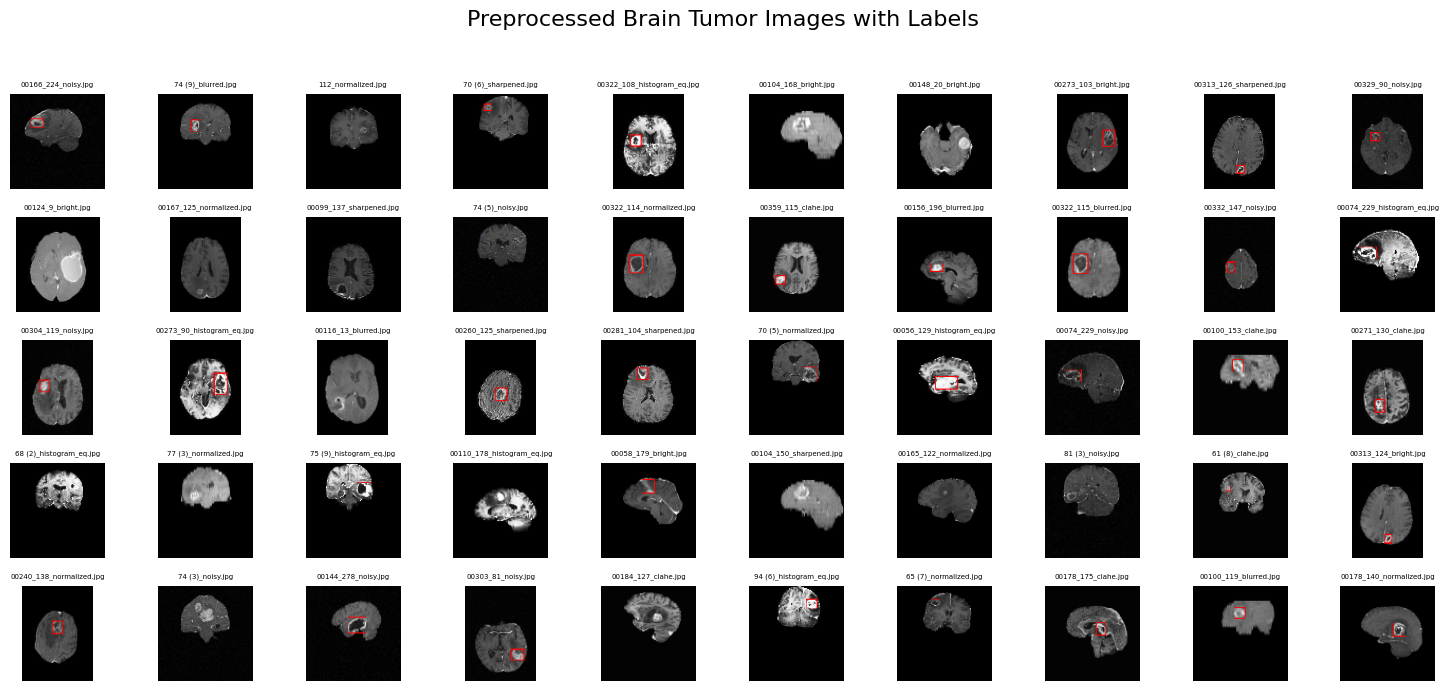

In [5]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# 경로 설정 (상대경로)
image_folder = "processed_train_images"
label_folder = "processed_train_labels"

# 이미지 리스트 (jpg, png 등)
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

sample_count = 50
if len(image_files) < sample_count:
    sample_count = len(image_files)

# 랜덤 50장 샘플링
sample_files = random.sample(image_files, sample_count)

cols, rows = 10, 5
fig, axes = plt.subplots(rows, cols, figsize=(15, 7))
fig.suptitle("Preprocessed Brain Tumor Images with Labels", fontsize=16)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i, ax in enumerate(axes.flat):
    if i >= sample_count:
        ax.axis('off')
        continue

    img_name = sample_files[i]
    img_path = os.path.join(image_folder, img_name)
    label_name = os.path.splitext(img_name)[0] + '.txt'
    label_path = os.path.join(label_folder, label_name)

    # 이미지 읽기 (OpenCV는 BGR)
    img = cv2.imread(img_path)
    if img is None:
        ax.axis('off')
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w, _ = img.shape

    # 라벨 읽어서 박스 그리기 (cls가 '1'인 것만 표시)
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls, x_c, y_c, bw, bh = parts
                if cls != '1':
                    continue
                x_c, y_c, bw, bh = map(float, [x_c, y_c, bw, bh])

                # YOLO 형식 중심좌표->절대좌표 변환
                xmin = int((x_c - bw / 2) * w)
                ymin = int((y_c - bh / 2) * h)
                xmax = int((x_c + bw / 2) * w)
                ymax = int((y_c + bh / 2) * h)

                # 빨간색 박스, 두께 2
                cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

    # 이미지 크기 조정 (가로 90 픽셀)
    base_width = 90
    scale_ratio = base_width / w
    new_h = int(h * scale_ratio)
    img = cv2.resize(img, (base_width, new_h))

    ax.imshow(img)
    ax.set_title(img_name, fontsize=5)
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # 제목 공간 확보
plt.show()


- 각 기법 적용 데이터

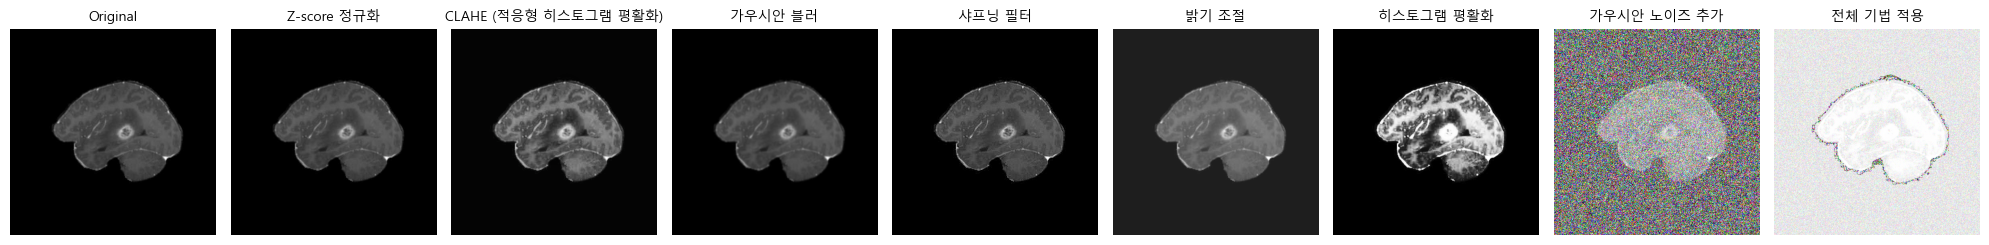

In [16]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- 이미지 폴더 경로 ---
original_img_folder = "images/train"

# --- 전처리 함수들 ---
def normalize_zscore(img):
    img_float = img.astype(np.float32)
    mean = np.mean(img_float)
    std = np.std(img_float)
    img_norm = (img_float - mean) / (std + 1e-7)
    img_norm = ((img_norm - img_norm.min()) / (img_norm.max() - img_norm.min()) * 255).astype(np.uint8)
    return img_norm

def apply_clahe(img):
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_lab[:, :, 0] = clahe.apply(img_lab[:, :, 0])
    img_clahe = cv2.cvtColor(img_lab, cv2.COLOR_LAB2BGR)
    return img_clahe

def apply_gaussian_blur(img):
    return cv2.GaussianBlur(img, (5, 5), 0)

def sharpen_image(img):
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    return cv2.filter2D(img, -1, kernel)

def adjust_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    lim = 255 - value
    v = np.where(v > lim, 255, v + value)
    final_hsv = cv2.merge((h,s,v))
    img_bright = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img_bright

def histogram_equalization(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img_eq

def add_gaussian_noise(img, mean=0, sigma=15):
    noise = np.random.normal(mean, sigma, img.shape).astype(np.uint8)
    img_noisy = cv2.add(img, noise)
    return img_noisy

# --- 전체기법 모두 적용 ---
def apply_all_preprocesses(img):
    img_proc = img.copy()
    img_proc = normalize_zscore(img_proc)
    img_proc = apply_clahe(img_proc)
    img_proc = apply_gaussian_blur(img_proc)
    img_proc = sharpen_image(img_proc)
    img_proc = adjust_brightness(img_proc)
    img_proc = histogram_equalization(img_proc)
    img_proc = add_gaussian_noise(img_proc)
    return img_proc

# --- 랜덤 원본 이미지 선택 ---
original_images = [f for f in os.listdir(original_img_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
if not original_images:
    raise FileNotFoundError(f"No images found in {original_img_folder}")
sample_img_name = random.choice(original_images)
sample_img_path = os.path.join(original_img_folder, sample_img_name)
img_orig = cv2.imread(sample_img_path)
if img_orig is None:
    raise FileNotFoundError(f"Failed to load image: {sample_img_path}")

# --- 각 기법 적용 ---
img_normalized = normalize_zscore(img_orig)
img_clahe = apply_clahe(img_orig)
img_blurred = apply_gaussian_blur(img_orig)
img_sharpened = sharpen_image(img_orig)
img_bright = adjust_brightness(img_orig)
img_hist_eq = histogram_equalization(img_orig)
img_noisy = add_gaussian_noise(img_orig)
img_all = apply_all_preprocesses(img_orig)

# --- 이미지와 제목 리스트 ---
images = [img_orig, img_normalized, img_clahe, img_blurred, img_sharpened, img_bright, img_hist_eq, img_noisy, img_all]
titles = [
    "Original",
    "Z-score 정규화",
    "CLAHE (적응형 히스토그램 평활화)",
    "가우시안 블러",
    "샤프닝 필터",
    "밝기 조절",
    "히스토그램 평활화",
    "가우시안 노이즈 추가",
    "전체 기법 적용"
]

# --- 출력 ---
plt.figure(figsize=(20,5))
for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), i+1)
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


- 가우시안 노이즈 제외 

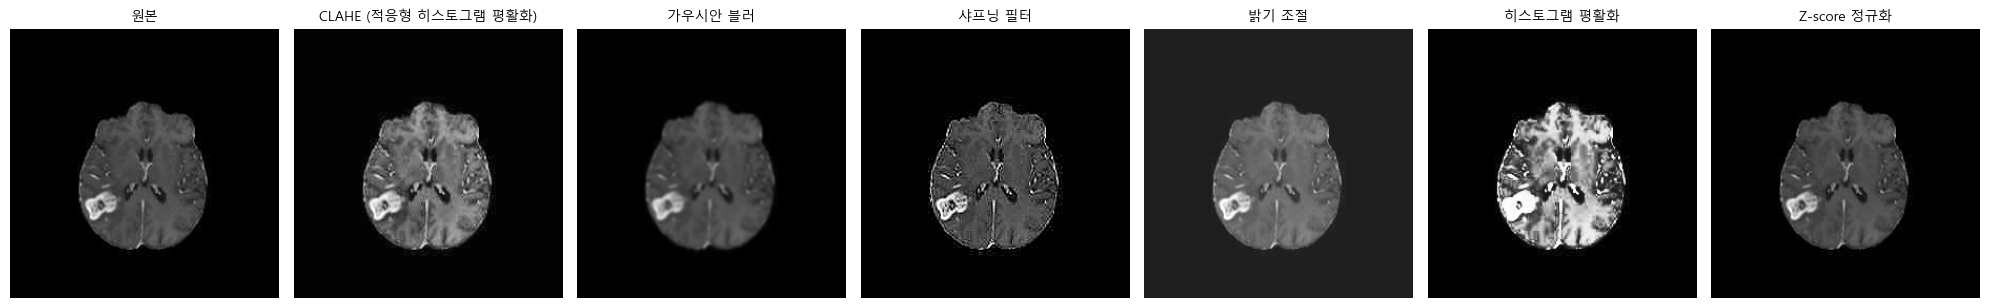

In [37]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- 전처리 함수들 ---
def normalize_zscore(img):
    img_f = img.astype(np.float32)
    mean = np.mean(img_f)
    std = np.std(img_f)
    if std < 1e-6:
        return img
    norm_img = (img_f - mean) / std
    norm_img = 255 * (norm_img - norm_img.min()) / (norm_img.max() - norm_img.min())
    return norm_img.astype(np.uint8)

def apply_clahe(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

def apply_gaussian_blur(img):
    return cv2.GaussianBlur(img, (5,5), 0)

def sharpen_image(img):
    kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
    return cv2.filter2D(img, -1, kernel)

def adjust_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    lim = 255 - value
    v = np.where(v > lim, 255, v + value).astype(np.uint8)
    hsv = cv2.merge([h,s,v])
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

def histogram_equalization(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

# --- 이미지 불러오기 ---
original_img_folder = "images/train"
img_files = [f for f in os.listdir(original_img_folder) if f.lower().endswith(('.png','.jpg','.jpeg'))]
random_img_name = random.choice(img_files)
img_path = os.path.join(original_img_folder, random_img_name)
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"{random_img_name} 이미지 로드 실패")

# --- 각각 기법 적용 ---
clahe_img = apply_clahe(img)
blur_img = apply_gaussian_blur(img)
sharpen_img = sharpen_image(img)
bright_img = adjust_brightness(img)
hist_eq_img = histogram_equalization(img)
zscore_img = normalize_zscore(img)

# --- 출력 준비 ---
titles = ["원본",
          "CLAHE (적응형 히스토그램 평활화)",
          "가우시안 블러",
          "샤프닝 필터",
          "밝기 조절",
          "히스토그램 평활화",
          "Z-score 정규화"]

images = [img, clahe_img, blur_img, sharpen_img, bright_img, hist_eq_img, zscore_img]

plt.figure(figsize=(20, 5))
for i, (title, image) in enumerate(zip(titles, images)):
    plt.subplot(1, len(images), i+1)
    # Z-score 정규화 이미지는 그레이스케일로 시각화
    if title == "Z-score 정규화":
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


- 원본 데이터 vs 전처리 데이터

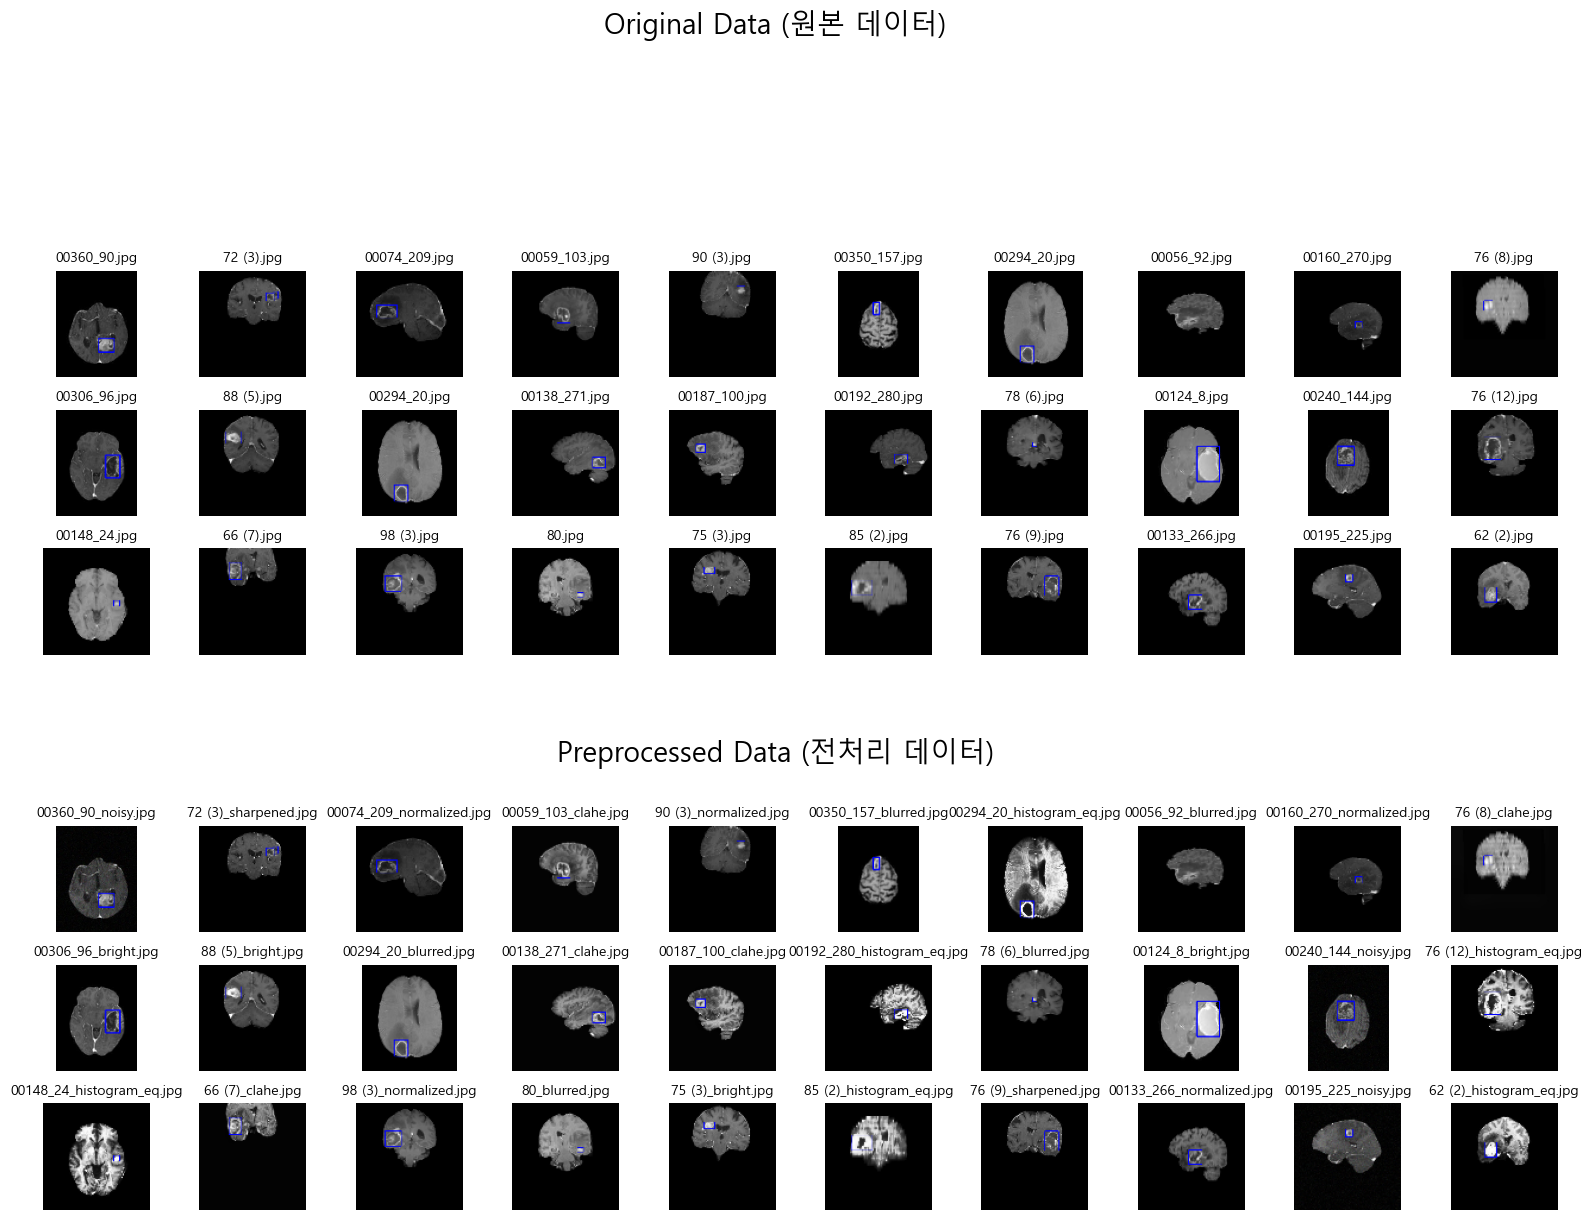

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 (윈도우용 맑은 고딕)
font_path = "C:/Windows/Fonts/malgun.ttf"
fontprop = fm.FontProperties(fname=font_path)

plt.rc('font', family=fontprop.get_name())
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지

processed_img_folder = "processed_train_images"
processed_label_folder = "processed_train_labels"
original_img_folder = "images/train"
original_label_folder = "labels/train"

processed_images = [f for f in os.listdir(processed_img_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
original_images_set = set(os.listdir(original_img_folder))

def find_original_filename(processed_filename):
    base_name = processed_filename
    for suffix in ['_normalized', '_clahe', '_blurred', '_sharpened', '_bright', '_histogram_eq', '_noisy']:
        if suffix in base_name:
            base_name = base_name.replace(suffix, '')
    base_name = os.path.splitext(base_name)[0]

    for ext in ['.jpg', '.jpeg', '.png']:
        candidate = base_name + ext
        if candidate in original_images_set:
            return candidate
    return None

# 매칭되는 파일만 필터링
matched_pairs = []
for p_img in processed_images:
    orig_img = find_original_filename(p_img)
    if orig_img is not None:
        matched_pairs.append((p_img, orig_img))

sample_count = min(30, len(matched_pairs))
sample_pairs = random.sample(matched_pairs, sample_count)

def draw_yolo_boxes(img, label_folder, img_filename):
    label_filename = os.path.splitext(img_filename)[0] + '.txt'
    label_path = os.path.join(label_folder, label_filename)
    h, w = img.shape[:2]

    if not os.path.exists(label_path):
        return img

    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, x_c, y_c, bw, bh = parts
            x_c, y_c, bw, bh = map(float, (x_c, y_c, bw, bh))
            xmin = int((x_c - bw / 2) * w)
            ymin = int((y_c - bh / 2) * h)
            xmax = int((x_c + bw / 2) * w)
            ymax = int((y_c + bh / 2) * h)
            color = (255, 0, 0)
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, 2)
    return img

img_width = 90
cols, rows = 10, 3

fig, axes = plt.subplots(rows * 2 + 2, cols, figsize=(20, 14))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

# 제목용 빈 축을 추가할 위치(맨 위 원본, 그리고 원본 아래 한 줄, 그리고 전처리 아래 한 줄)
for c in range(cols):
    axes[0, c].axis('off')  # 첫 줄은 제목용 빈축
    axes[rows + 1, c].axis('off')  # 중간 구분용 빈축

# 상단 제목: Original Data (원본 데이터)
fig.text(0.5, 0.95, "Original Data (원본 데이터)", ha='center', fontsize=20, weight='bold', fontproperties=fontprop)

# 하단 제목: Preprocessed Data (전처리 데이터)
fig.text(0.5, 0.43, "Preprocessed Data (전처리 데이터)", ha='center', fontsize=20, weight='bold', fontproperties=fontprop)

for i in range(sample_count):
    processed_name, original_name = sample_pairs[i]

    # 원본 이미지 위치: 1 ~ rows (즉 axes[1~rows, col])
    ax_orig = axes[1 + i // cols, i % cols]
    img_path = os.path.join(original_img_folder, original_name)
    img = cv2.imread(img_path)
    if img is not None:
        img = draw_yolo_boxes(img, original_label_folder, original_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        scale = img_width / w
        new_h = int(h * scale)
        img = cv2.resize(img, (img_width, new_h))
        ax_orig.imshow(img)
        ax_orig.axis('off')
        ax_orig.set_title(original_name, fontsize=7, fontproperties=fontprop)
    else:
        ax_orig.axis('off')

    # 전처리 이미지 위치: rows+2 ~ rows*2+1 (즉 axes[rows+2 ~ rows*2+1, col])
    ax_proc = axes[rows + 2 + (i // cols), i % cols]
    img_path = os.path.join(processed_img_folder, processed_name)
    img = cv2.imread(img_path)
    if img is not None:
        img = draw_yolo_boxes(img, processed_label_folder, processed_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        scale = img_width / w
        new_h = int(h * scale)
        img = cv2.resize(img, (img_width, new_h))
        ax_proc.imshow(img)
        ax_proc.axis('off')
        ax_proc.set_title(processed_name, fontsize=7, fontproperties=fontprop)
    else:
        ax_proc.axis('off')

plt.show()
